# **Structure-performance relationships for catalysis-driven molecular machinery**

In this Jupyter notebook we produce an interactive visualization of the flux through different types of cycles in a molecular motor as its design parameters vary.

To run this Jupyter notebook click on "Run all" or "Runtime -> Run all". Scroll to the bottom of the page to see the interactive visualization.

## **Set up**

Code for the generation of the figures.

In [11]:
from google.colab import output
output.enable_custom_widget_manager()

In [12]:
import numpy as np
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from ipywidgets import FloatSlider, VBox, HBox

# ---------- maths ----------
def get_fluxes(mu, ln_q, W, slip, futile):
    """Return 8 fluxes."""
    sqrt_q, sqrt_Q, sqrt_W = np.exp(ln_q/2), np.exp(mu/2), np.exp(W/2)
    F,  Ft = sqrt_q * sqrt_Q / sqrt_W, sqrt_q / sqrt_Q * sqrt_W
    B,  Bt = 1 / sqrt_q * sqrt_Q * sqrt_W, 1 / sqrt_q / sqrt_Q / sqrt_W
    S,  St = slip / sqrt_q / sqrt_W, slip / sqrt_q * sqrt_W
    C,  Ct = futile / sqrt_q * sqrt_Q, futile / sqrt_q / sqrt_Q
    return F, Ft, B, Bt, S, St, C, Ct

# ───────────────── colours / labels ─────
cols      = ["#007134", "#7fb799", "#BA0D20", "#dc858f"] + ["#9292C9"]*4
rot_cols  = [cols[0], cols[3], cols[4], cols[1], cols[2], cols[5]]
rot_labs  = ["F", "B⁺", "S", "F⁺", "B", "S⁺"]
fuel_cols = [cols[0], cols[2], cols[6], cols[1], cols[3], cols[7]]
fuel_labs = ["F", "B", "C", "F⁺", "B⁺", "C⁺"]


# ───────────────── helpers ──────────────
def add_seg(fig, *, row, col, x, label, colour):
    """Add a single stacked-bar trace (initial y=0)."""
    fig.add_trace(
        go.Bar(
            x=x, y=[0, 0],
            marker=dict(color=colour, line=dict(color="black", width=1)),
            hovertemplate=f"{label}: %{{y:.3f}}<extra></extra>",
            showlegend=False,
            name=label,
        ),
        row=row, col=col,
    )


def build_skeleton() -> go.Figure:
    """Figure with all traces in place (heights zero)."""
    fig = make_subplots(
        rows=1, cols=3,
        column_widths=[2.5, 1, 1],
        subplot_titles=("All fluxes", "Mechanical flux", "Chemical flux"),
    )
    # left panel - eight solo bars
    fig.add_trace(
        go.Bar(
            x=["F", "F⁺", "B", "B⁺", "S", "S⁺", "C", "C⁺"],
            y=[0]*8,
            marker=dict(color=cols, line=dict(color='black', width=1)),
            hovertemplate="%{x}: %{y:.3f}<extra></extra>",
            showlegend=False,
        ),
        row=1, col=1,
    )
    # middle panel - rotation
    for lab, c in zip(rot_labs, rot_cols):
        add_seg(fig, row=1, col=2, x=["Clockwise", "Counterclockwise"], label=lab, colour=c)
    # right panel - fuel
    for lab, c in zip(fuel_labs, fuel_cols):
        add_seg(fig, row=1, col=3, x=["Fuel to waste", "Waste to fuel"], label=lab, colour=c)

    fig.update_layout(
        barmode="stack", template="simple_white",
        bargap=0.15, width=850, height=450,
        margin=dict(l=30, r=10, t=30, b=30),
    )
    fig.update_xaxes(showline=False, ticks=""); fig.update_yaxes(zeroline=False)
    fig.update_yaxes(title_text="Flux", row=1, col=1)# anywhere after figw is created
    fig.update_xaxes(title_text="Type of cycle", row=1, col=1)

    return fig


# ───────────────── build widgets ────────
figw = go.FigureWidget(build_skeleton())

μ_sl    = FloatSlider(value=1.3, min=0, max=4, step=0.1, description="μ")
lnq_sl  = FloatSlider(value=1.0, min=0, max=3, step=0.1, description="ln(q)")
W_sl    = FloatSlider(value=0.0, min=-4, max=4, step=0.1, description="W")
slip_sl = FloatSlider(value=0.1, min=0,  max=10, step=0.01, description="Γ")
fut_sl  = FloatSlider(value=0.1, min=0,  max=10, step=0.01, description="Λ")


# ───────────────── callback ─────────────
def update(_=None):
    F, Ft, B, Bt, S, St, C, Ct = get_fluxes(
        μ_sl.value, lnq_sl.value, W_sl.value, slip_sl.value, fut_sl.value
    )

    # left panel
    figw.data[0].y = [F, Ft, B, Bt, S, St, C, Ct]

    # middle panel (traces 1–6)
    for t, pair in zip(
        figw.data[1:7],
        ([F, 0], [Bt, 0], [S, 0], [0, Ft], [0, B], [0, St]),
    ):
        t.y = pair

    # right panel (traces 7–12)
    for t, pair in zip(
        figw.data[7:],
        ([F, 0], [B, 0], [C, 0], [0, Ft], [0, Bt], [0, Ct]),
    ):
        t.y = pair


for s in (μ_sl, lnq_sl, W_sl, slip_sl, fut_sl):
    s.observe(update, names='value')


# ───────────────── expose to notebook ───
box = VBox([figw,
      HBox([μ_sl, lnq_sl, W_sl]),
      HBox([slip_sl, fut_sl])])

def _init_on_frontend(_): update()
figw.on_displayed(_init_on_frontend)

In [13]:
# vector, razor-sharp
%config InlineBackend.figure_format = 'svg'      # or: 'pdf'

In [14]:
import matplotlib.pyplot as plt


# dataset for the two legend tables
table1 = [
    ["F", "Forward"],
    ["F⁺", "Forward reverse"],
    ["B", "Backward"],
    ["B⁺", "Backward reverse"],
    ["S", "Slip"],
    ["S⁺", "Slip reverse"],
    ["C", "Futile cycling"],
    ["C⁺", "Reverse futile cycling"],
]

table2 = [
    ["μ", "Driving chemical potential"],
    ["W", "Work per cycle"],
    ["ln q", "Kinetic asymmetry"],
    ["Λ", "Futile-cycle propensity"],
    ["Γ", "Slipping propensity"],
]

# build single-axis figure with two side-by-side tables
fig, ax = plt.subplots(figsize=(6, 4))
ax.axis("off")  # hide axis frame

#–––– left legend ––––
tbl1 = ax.table(
    cellText=table1,
    colLabels=["Symbol", "Meaning"],
    colWidths=[0.08, 0.17],
    cellLoc="center",
    colLoc="center",
    bbox=[0.35, 0.00, 0.44, 0.50],
)

#–––– right legend ––––
tbl2 = ax.table(
    cellText=table2,
    colLabels=["Symbol", "Meaning"],
    colWidths=[0.12, 0.45],
    cellLoc="center",
    colLoc="center",
    bbox=[0.87, 0.00, 0.50, 0.40],
)


for tbl in [tbl1, tbl2]:
  tbl.auto_set_font_size(False)
  tbl.set_fontsize(8)
  tbl.scale(0.5, 0.65)

plt.close(fig)

## **Figure**

The following figure shows how the flux through the forward, backward, slip, futile cycles and their microscopic reverses varies as the properties of the molecular motor change. The flux through each of these cycles is also shown aggregated by their respective contributions to the mechanical and chemical flux.

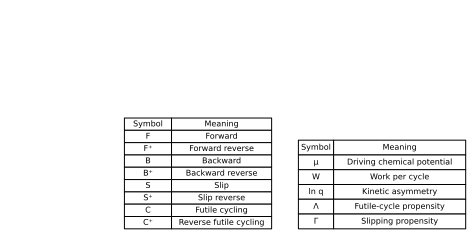

    'data': [{'hovertemplate': '%{x}: %{y:.3f}<extra></extra>',
              'm…

In [15]:
display(fig)
display(box)
update(box)